In [63]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [64]:
df_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")
df_rndbkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [65]:
columns = df_purebkg.columns

In [66]:
df_purebkg.head()

,Mjj,j1 pT,j2 pT,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 tau54,j1 tau65,j1 tau76,...,j2 tau76,j2 tau87,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1
0,2308.313028,1405.544993,697.776317,128.326132,0.189019,0.911555,0.849721,0.915593,0.883393,0.885878,...,0.810412,0.862825,2.003320,76.0,36.389206,30.116799,31.486846,31.486846,36.389206,-0.000011
1,2433.658374,1218.344352,1181.231345,168.702659,0.471191,0.668339,0.835098,0.829574,0.954969,0.914275,...,0.915983,0.919871,1.591575,284.0,86.360518,78.302729,83.267629,87.636863,87.636863,-0.000003
2,2687.853262,1370.333269,1278.656676,259.775966,0.272282,0.834496,0.905154,0.881008,0.916023,0.941925,...,0.838064,0.842752,2.694852,212.0,142.759911,17.207589,5.411157,161.894075,161.894075,0.000002
3,3020.510484,1526.551452,999.484105,227.093270,0.681522,0.636388,0.861016,0.887311,0.927072,0.939647,...,0.897310,0.908369,1.343559,252.0,116.511073,109.874007,109.874007,109.874007,133.288161,-0.000005
4,2285.694841,1391.822493,618.616945,118.372552,0.456816,0.713677,0.644830,0.802596,0.812279,0.797923,...,0.880661,0.869124,1.776008,256.0,86.433637,101.312752,113.277482,113.277482,113.277482,0.000001


In [327]:
whichbkg = 'purebkg'
#whichbkg = 'rndbkg'

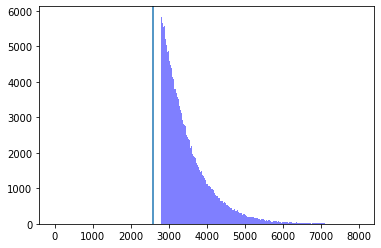

In [328]:
bins = np.linspace(0,8000,1000)
bins.shape
column = 0
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(2600)

In [329]:
whichbkg

'purebkg'

In [330]:
columns[16]

'j1 M_sdb1'

In [331]:
columns

Index(['Mjj', 'j1 pT', 'j2 pT', 'Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43',
       'j1 tau54', 'j1 tau65', 'j1 tau76', 'j1 tau87',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j1 M_trim', 'j1 M_prun',
       'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2', 'j1 M_sdm1', 'Mj2', 'j2 tau21',
       'j2 tau32', 'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 tau76', 'j2 tau87',
       'j2 sqrt(tau^2_1)/tau^1_1', 'j2 n_trk', 'j2 M_trim', 'j2 M_prun',
       'j2 M_mmdt', 'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1'],
      dtype='object')

In [332]:
columns[20]

'j2 tau21'

In [333]:
columns[[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

Index(['j1 tau21', 'j1 tau32', 'j1 tau43', 'j1 tau54', 'j1 tau65',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j2 tau21', 'j2 tau32',
       'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 sqrt(tau^2_1)/tau^1_1',
       'j2 n_trk'],
      dtype='object')

In [334]:
if whichbkg == 'purebkg':
    dt = df_purebkg.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) &(dt[:,1]>0) &(dt[:,2]>0)&(dt[:,16]>0)&(dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
        
    correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    correct = (dt[:,0]>=2800)
    dt = dt[correct]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    
    
    
if whichbkg == 'rndbkg':
    dt = df_rndbkg.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) &(dt[:,1]>0) &(dt[:,2]>0)&(dt[:,16]>0)&(dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,16]>0) &(dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]   
    correct = (dt[:,0]>=2800)
    dt = dt[correct]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    idx = dt[:,-1]
    bkg_idx = np.where(idx==0)[0]
    signal_idx = np.where(idx==1)[0]
    dt = dt[bkg_idx]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    
    

In [354]:
qcdlike = np.where(dt[:,16]<0.9)[0]
bsmlike = np.where(dt[:,16]>0.9)[0]

In [355]:
dt_bsmlike = dt[bsmlike]

In [356]:
hightau21 = np.where(dt[:,4]>0.8)[0]
lowtau21 = np.where(dt[:,4]<0.2)[0]

In [357]:
j1sdb = dt[:,3]*dt[:,16]

In [358]:
j1sdb_bsmlike = dt_bsmlike[:,3]*dt_bsmlike[:,16]

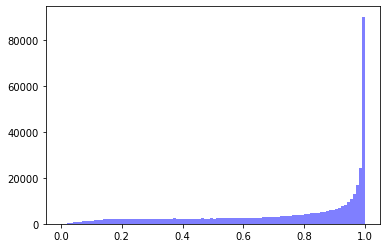

In [359]:
bins = np.linspace(0,1,101)
bins.shape
column = 16
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

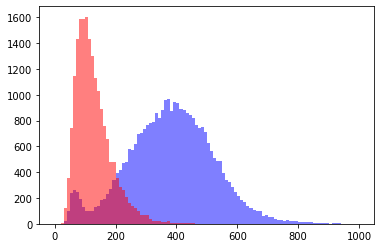

In [360]:
bins = np.linspace(0,1000,101)
bins.shape
column = 3
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[lowtau21,column],bins,alpha=0.5,color='b');
plt.hist(dt[hightau21,column],bins,alpha=0.5,color='r');

#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

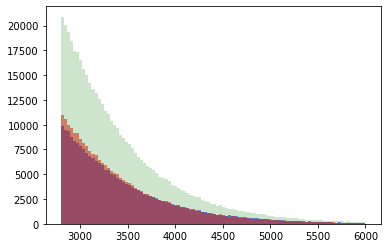

In [361]:
bins = np.linspace(2800,6000,101)
bins.shape
column = 0
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[qcdlike,column],bins,alpha=0.5,color='b');
plt.hist(dt[bsmlike,column],bins,alpha=0.5,color='r');
plt.hist(dt[:,column],bins,alpha=0.2,color='g');

#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

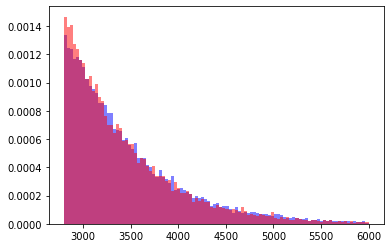

In [362]:
bins = np.linspace(2800,6000,101)
bins.shape
column = 0
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[lowtau21,column],bins,density=True, alpha=0.5,color='b');
plt.hist(dt[hightau21,column],bins,density=True, alpha=0.5,color='r');
#plt.hist(dt[:,column],bins,alpha=0.2,color='g');

#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

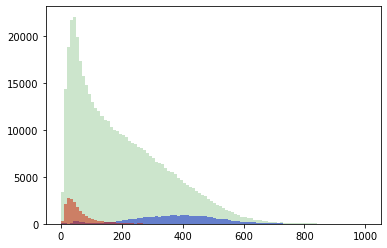

In [363]:
bins = np.linspace(0,1000,101)
bins.shape
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(j1sdb[lowtau21],bins,alpha=0.5, color='b');
plt.hist(j1sdb[hightau21],bins,alpha=0.5, color='r');
plt.hist(j1sdb[:],bins,alpha=0.2,color='g');

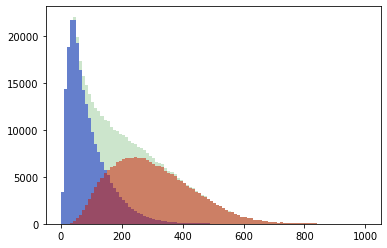

In [364]:
bins = np.linspace(0,1000,101)
bins.shape
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(j1sdb[qcdlike],bins,alpha=0.5,color='b');
plt.hist(j1sdb[bsmlike],bins,alpha=0.5,color='r');
plt.hist(j1sdb[:],bins,alpha=0.2,color='g');

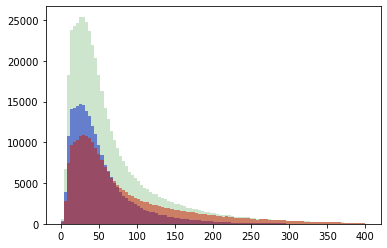

In [365]:
bins = np.linspace(0,400,101)
bins.shape
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(j2sdb[qcdlike],bins,alpha=0.5,color='b');
plt.hist(j2sdb[bsmlike],bins,alpha=0.5,color='r');
plt.hist(j2sdb[:],bins,alpha=0.2,color='g');

In [366]:
bsmlike_hightau21 = np.where(dt_bsmlike[:,4]>0.5)[0]
bsmlike_lowtau21 = np.where(dt_bsmlike[:,4]<0.5)[0]

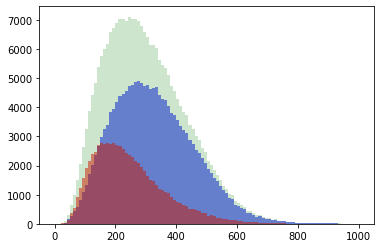

In [367]:
bins = np.linspace(0,1000,101)
bins.shape
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(j1sdb_bsmlike[bsmlike_lowtau21],bins,alpha=0.5, color='b');
plt.hist(j1sdb_bsmlike[bsmlike_hightau21],bins,alpha=0.5, color='r');
plt.hist(j1sdb_bsmlike[:],bins,alpha=0.2,color='g');

In [368]:
len(qcdlike)

229222

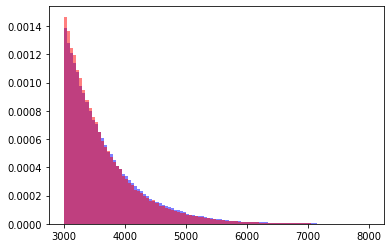

In [369]:
bins = np.linspace(3000,8000,101)
bins.shape
column = 0
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[qcdlike,column],bins,alpha=0.5,density=True,color='b');
plt.hist(dt[bsmlike,column],bins,alpha=0.5,density=True,color='r');
#plt.hist(dt[:,column],bins,alpha=0.2,density=True,color='g');

#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [370]:
j1sdb = dt[:,3]*dt[:,16]

In [371]:
j2sdb = dt[:,19]*dt[:,32]

In [372]:
np.min(j2sdb)

7.62939453125e-06

In [373]:
mrange = j1sdb > 200

In [396]:
pt = dt[mrange,1]
m = j1sdb[mrange]
m2 = j2sdb[mrange]
tau21 = dt[mrange,4]
tau32 = dt[mrange,5]
tau43 = dt[mrange,6]
tau54 = dt[mrange,7]
tau65 = dt[mrange,8]
massratio = dt[mrange,16]



In [375]:
rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

In [376]:
tau21prime = tau21 + rhoprime * 0.09

In [377]:
tau32prime = tau32 + rhoprime * 0.025

In [378]:
tau43prime = tau43 + rhoprime * 0.005202326545352761

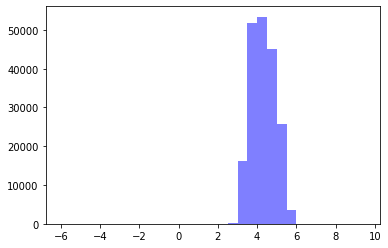

In [379]:
plt.hist(rhoprime,bins=np.arange(-6,10,0.5),alpha=0.5,density=False,color='b');

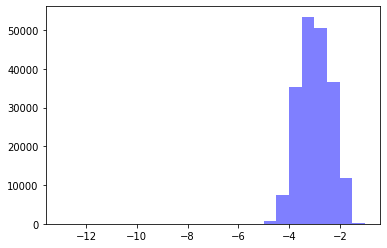

In [380]:
plt.hist(rho,bins=np.arange(-13,-0.5,0.5),alpha=0.5,density=False,color='b');

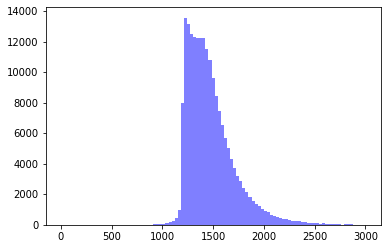

In [381]:
plt.hist(pt,bins=np.linspace(0,3000,100),alpha=0.5,density=False,color='b');

In [382]:
bins = np.arange(-12,0,1)
print(bins)

[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1]


In [383]:
whichbkg

'purebkg'

[2.75 3.25 3.75 4.25 4.75 5.25]
0.7751353437783063 -0.0007014029647714172


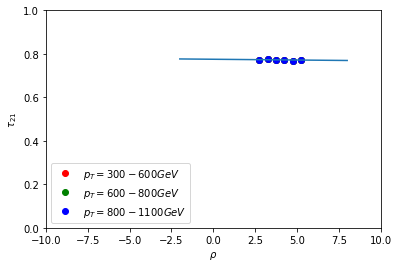

In [392]:
bins = np.arange(2.5,6,.5)
bincenters = 0.5*(bins[1:]+bins[:-1])
y1 = []
y2 = []
y3 = []
for i in range(len(bins)-1):
    rho_range_mask_1 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000)
    rho_range_mask_2 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000) #& (dt[mrange,32]<0.5)
    rho_range_mask_3 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000) #& (dt[mrange,32]>0.9)
    #print(tau21[rho_range_mask_1])
    y1.append(np.average(tau21prime[rho_range_mask_1]))
    y2.append(np.average(tau21prime[rho_range_mask_2]))
    y3.append(np.average(tau21prime[rho_range_mask_3]))

print(bincenters)
plt.xlim(-10,10)
plt.ylim(0,1)
slope,b = np.polyfit(bincenters[:],y2[:],1) 
print(b,slope)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\tau_{21}$')
plt.plot(bincenters,y1,color='r',marker='o',linestyle='None',label=r'$p_{T} = 300-600 GeV$')
plt.plot(bincenters,y2,color='g',marker='o',linestyle='None',label=r'$p_{T} = 600-800 GeV$')
plt.plot(bincenters,y3,color='b',marker='o',linestyle='None',label=r'$p_{T} = 800-1100 GeV$')
plt.legend()
fitx = np.linspace(-2,8,100)
plt.plot(fitx,b+slope*fitx, '-', label=f'fit function: slope {slope:.3f}')
#plt.savefig('tau21avg_rho_plot.png')
#plt.savefig('tau21avg_rho_plot.pdf')
                 

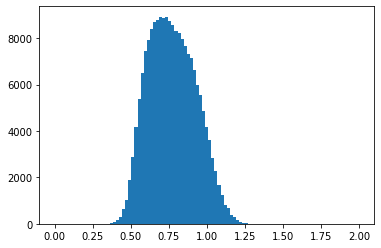

In [393]:
plt.hist(tau21prime,bins=np.linspace(0,2,100));

In [394]:
len(tau21prime)

196200

In [397]:
len(m)

196200

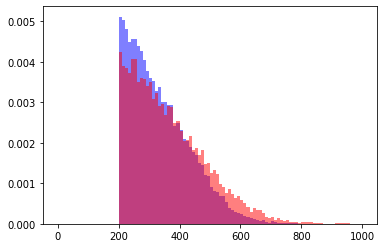

In [403]:
bins = np.linspace(0,1000,101)
bins.shape
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(m[tau21prime<0.6],bins,alpha=0.5, density=True, color='b');
plt.hist(m[tau21prime>1],bins,alpha=0.5, density=True, color='r');
#plt.hist(m[:],bins,alpha=0.2,density=True, color='g');

In [ ]:
bins = np.linspace(0,1,101)
bins.shape
column = 4
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(dt[bsmlike,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [59]:
qcdlike = np.where(dt[:,16]<0.9)[0]
bsmlike = np.where(dt[:,16]>0.9)[0]

In [60]:
hightau21 = np.where(dt[:,4]>0.8)[0]
lowtau21 = np.where(dt[:,4]<0.2)[0]

In [51]:
print(len(qcdlike),len(bsmlike))

298780 317061


In [11]:
dt.shape

(615841, 35)

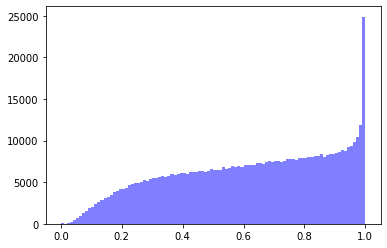

In [12]:
bins = np.linspace(0,1,101)
#bins.shape
#column = 
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,21],bins=bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(2600)

In [13]:
bkg_mean = []
bkg_std = []

In [14]:
for i in range(24):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

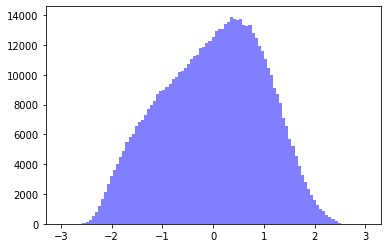

In [15]:
bins = np.linspace(-3,3,100)
bins.shape
column = 1
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [16]:
print((Y[:20,11]))

[-0.5861682  -0.58616817 -0.5861683  -0.58616809  1.7292685  -0.58616815
 -0.58616819 -0.58616828 -0.58616815 -0.58616815  1.61545637 -0.58616809
  1.24521374 -0.58616818 -0.58616847 -0.58616815 -0.58616815 -0.58616819
 -0.58616815  1.7292685 ]


In [17]:
Y.shape

(615841, 24)

In [18]:
print(np.mean(Y[:,11]),np.max(Y[:,11]))

8.777353021794525e-17 43.8518568507264


In [19]:
bkg_mean

[228.52294279892652,
 0.4997777752063748,
 0.7065325299466477,
 0.8011350299207263,
 1.915762567105034,
 257.82551015603053,
 0.7998380345989512,
 0.6152056597263476,
 0.624420470496652,
 0.778588745492737,
 0.8558044548651736,
 0.25315663614904593,
 102.8982061807184,
 0.587218142367615,
 0.7379531576568646,
 0.8022270931538638,
 2.3804458123280647,
 162.21576023681436,
 0.6930998192664075,
 0.4466542519085117,
 0.43145202467024296,
 0.6217623607986256,
 0.723655012398563,
 0.026335737202509896]

In [20]:
bkg_std

[128.640229513228,
 0.18660650910286844,
 0.1282492285462693,
 0.08604305472700707,
 0.7711622403898504,
 110.22377920539722,
 0.21987374072735305,
 0.3213806737322414,
 0.373345996938908,
 0.2878084859802598,
 0.23119359751235152,
 0.43188398165942893,
 65.04622760994712,
 0.17378974614308512,
 0.11375678271407981,
 0.08354598126428656,
 1.0735007684295939,
 84.06116783412527,
 0.22693400287789967,
 0.2601303074333591,
 0.30344421805757854,
 0.25708436813009805,
 0.22273896064345658,
 0.1554552121792627]

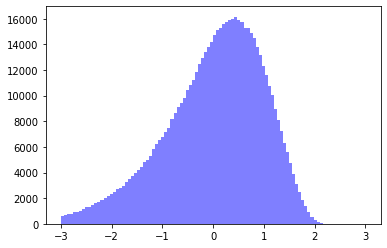

In [21]:
bins = np.linspace(-3,3,101)
plt.hist(Y[:,2],bins,alpha=0.5,color='b');

In [22]:
total_PureBkg = torch.tensor(Y)

total_PureBkg_selection = total_PureBkg

In [23]:
total_PureBkg_selection.shape

torch.Size([615841, 24])

In [24]:
bs = 1000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [25]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(24, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 24)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [22]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(24, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 24)
        )
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [26]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 6
Z_DIM = 8

n_steps = 0

In [27]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [41]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [29]:
beta = 0.1

In [30]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        
        
        
        mseloss = nn.MSELoss(size_average=False)
        
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [31]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [32]:
print(beta)

0.1


In [33]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=50, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=50, out_features=24, bias=True)
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): MAF(
        (layers): ModuleList(
          (0): FCNN(
            (network): Sequential(
              (0): Linear(in_features=1, out_features=8, bias=True)
              (1): Tanh()
              (2): Linear(in_features=8, out_features=8, bias=True)
              (3): Tanh()
              (4): Linear(in_features=8, out_features=2, bias=True)

In [43]:
N_EPOCHS = 10
#BEST_LOSS = 99
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkgae_purebkg_CwolaMassRatio_MAF_withturnoncuts_MSEloss_beta0p1.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -0.2729 Time: 6.308 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -0.2929 Time: 6.282 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -0.2785 Time: 6.513 s
Not saving model! Last saved: 2
Epoch 4:

Evaluation Completed (valid)!	Loss: -0.3428 Time: 6.504 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -0.3562 Time: 6.475 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -0.3597 Time: 6.507 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -0.3812 Time: 6.554 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -0.4245 Time: 6.473 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -0.4473 Time: 6.492 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: -0.4477 Time: 6.525 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -0.4818 Time: 6.481 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: -0.5001 Time: 6.556 s
Saving mo


Evaluation Completed (valid)!	Loss: -1.3450 Time: 6.513 s
Not saving model! Last saved: 83
Epoch 92:

Evaluation Completed (valid)!	Loss: -1.3711 Time: 6.503 s
Not saving model! Last saved: 83
Epoch 93:

Evaluation Completed (valid)!	Loss: -1.4470 Time: 6.526 s
Saving model!
Epoch 94:

Evaluation Completed (valid)!	Loss: -1.4276 Time: 6.501 s
Not saving model! Last saved: 93
Epoch 95:

Evaluation Completed (valid)!	Loss: -1.2206 Time: 6.458 s
Not saving model! Last saved: 93
Epoch 96:

Evaluation Completed (valid)!	Loss: -1.4048 Time: 6.502 s
Not saving model! Last saved: 93
Epoch 97:

Evaluation Completed (valid)!	Loss: -1.4888 Time: 6.502 s
Saving model!
Epoch 98:

Evaluation Completed (valid)!	Loss: -1.5077 Time: 6.450 s
Saving model!
Epoch 99:

Evaluation Completed (valid)!	Loss: -1.4098 Time: 6.464 s
Not saving model! Last saved: 98
Epoch 100:

Evaluation Completed (valid)!	Loss: -1.4357 Time: 6.431 s
Not saving model! Last saved: 98
Epoch 101:

Evaluation Completed (valid)!	Loss

In [44]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkgae_purebkg_CwolaMassRatio_MAF_withturnoncuts_MSEloss_beta0p1.h5"))

<All keys matched successfully>

## Testing the bkg ae

In [46]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [47]:
outputlist = [
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_bb1.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_bb2.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_bb3.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_purebkg.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_rndbkg.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_2prong.npy',
    '../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_3prong.npy',
]

In [48]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong'
]

(914617, 24)
[0.23594344 0.12186224 0.41490608 0.15996468 1.1003678  0.20322296
 0.54330343 0.8776617  0.16778898 0.42420197]
(902602, 24)
[0.3093449  0.45522484 0.2618697  0.4197769  0.28796986 0.5919444
 0.2599037  0.59000844 1.1569065  0.08955679]
(938250, 24)
[0.5776026  0.16222127 3.7504141  0.3701917  0.17780894 0.29095787
 0.2978248  0.18877344 2.108192   0.4787008 ]
(930647, 24)
[0.147969   0.66990376 0.99251103 0.2942542  0.407141   0.62795734
 0.16123036 0.24661268 0.26047057 0.26907557]
(938331, 24)
[1.326243   0.36155316 0.31444284 0.21511962 0.17481719 0.2874494
 0.10322359 0.14915107 0.34959164 0.5543301 ]
(57042, 24)
[0.43431032 0.12256251 0.1520281  2.751366   0.19655313 0.13414739
 0.3280985  0.52788585 2.8067575  0.37003198]
(58822, 24)
[0.41409945 0.30597234 0.23992598 0.30518812 0.55912554 1.8072603
 0.56421566 0.37299758 0.24126461 0.6354995 ]


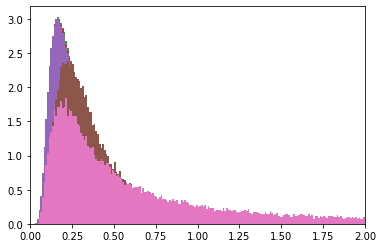

In [49]:
for in_file, out_file, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist,exist_signalflag,is_signal, nprong):
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values

    correct = (dt[:,3]>0) &(dt[:,19]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
        
    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    
    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            Y = Y[sigidx]
        else:
            Y = Y[bkgidx]
            
    if n_prong == '2prong':
        correct = Y[:,0] > 300
        Y = Y[correct]
    
    if n_prong == '3prong':
        correct = Y[:,0] > 400
        Y = Y[correct]
        
    
            
    print(Y.shape)
    for i in range(24):
        Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file,waic)

In [50]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_withmass_turnonselection_MSEloss_beta0p1_WAICloss_rndbkg.npy')



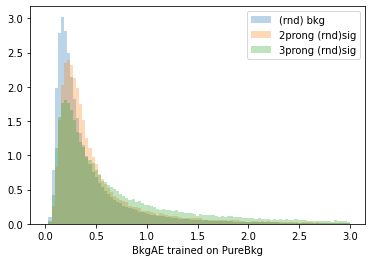

In [51]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,3,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,3,100),density=True,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,3,100),density=True,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

In [53]:
def reconstruct(X):
    out = model(torch.tensor(X[:100000]).float().cuda())[0]
    out = out.data.cpu().numpy()
    return out

In [54]:
out = reconstruct(Y)

In [55]:
out.shape

(100000, 24)

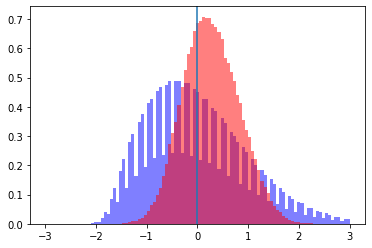

In [62]:
bins = np.linspace(-3,3,100)
bins.shape
column = 5
#print(df.coluns[column])
plt.hist(Y[:,column],bins,density=True,alpha=0.5,color='b');
plt.hist(out[:,column],bins,density=True,alpha=0.5,color='r');
plt.axvline(np.mean(Y[:,column]))

In [97]:
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5')

In [98]:
dt = f_bb.values

In [99]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [100]:
Y.shape

(78233, 24)

In [101]:
idx = dt[:,-1]
sigidx = idx == 1
bkgidx = idx == 0

In [108]:
for i in range(24):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

In [102]:
Y = Y[sigidx]

In [103]:
#correct = Y[:,0] > 300 #(For 2prong)
correct = Y[:,0] > 400 # (for 3prong)

In [104]:
Y = Y[correct]

In [105]:
Y.shape

(58822, 24)

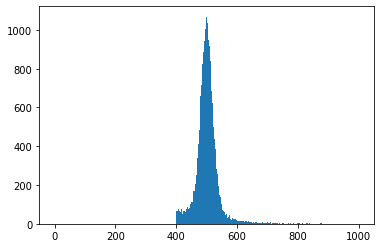

In [106]:
plt.hist(Y[:,0],bins=np.linspace(0,1000,1001));

In [109]:
np.mean(Y[:,0])

2.3954654567608404

In [110]:
total_bb_test = torch.tensor(Y)
bkgae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [111]:
bkgae_bbloss

array([0.38415718, 0.4250854 , 0.79621285, ..., 0.53214365, 0.62708235,
       0.52163726], dtype=float32)

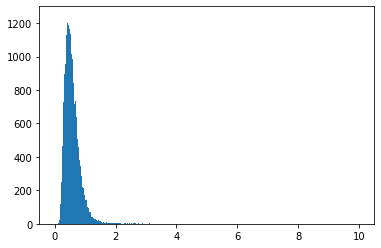

In [112]:
plt.hist(bkgae_bbloss,bins=np.linspace(0,10,1001));

In [113]:
np.save('../data_strings/bkgae_rndbkg_loss_3prong.npy',bkgae_bbloss)

In [52]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_loss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_loss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_loss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_loss_rndbkg.npy')

In [162]:
len(loss_purebkg)

930647

In [117]:
len(loss_prong2)

57042

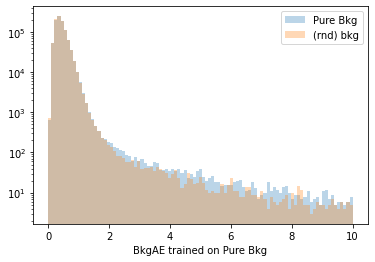

In [63]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_purebkg)),alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_rndbkg))*(len(loss_purebkg)/len(loss_rndbkg)),alpha=0.3,label='(rnd) bkg');

#plt.hist(loss_prong3,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong3))*(len(loss_purebkg)/len(loss_prong3)),alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong2,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong2))*(len(loss_purebkg)/len(loss_prong2)),alpha=0.3,label='3prong (rnd)sig');
plt.yscale('log')
plt.xlabel('BkgAE trained on Pure Bkg')
plt.legend(loc='upper right')
plt.savefig('bkgae_trained_on_pure_bkg_onlybkg.png')

In [97]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [98]:
bb1_loss_bkg = get_loss(X_bb1)

200


In [99]:
bb1_loss_bkg = np.array(bb1_loss_bkg,dtype=np.float)

In [100]:
bb1_loss_bkg

array([0.34203148, 0.20688626, 0.77139115, ..., 0.58295715, 0.60273141,
       0.670748  ])

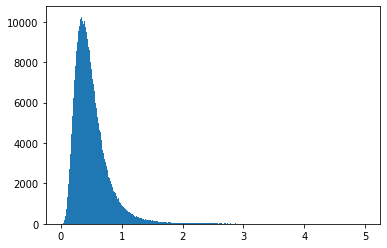

In [101]:
plt.hist(bb1_loss_bkg,bins=np.linspace(0,5,1001));

In [102]:
np.save('../data_strings/bkgaeloss_bb1.npy',bb1_loss_bkg)

In [103]:
f_bb2 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5')
dt_bb2 = f_bb2.values

In [104]:
X_bb2 = dt_bb2[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [105]:
for i in range(12):
    X_bb2[:,i] = (X_bb2[:,i]-bkg_mean[i])/bkg_std[i]

In [106]:
bb2_loss_bkg = get_loss(X_bb2)

200


In [107]:
bb2_loss_bkg = np.array(bb2_loss_bkg,dtype=np.float)

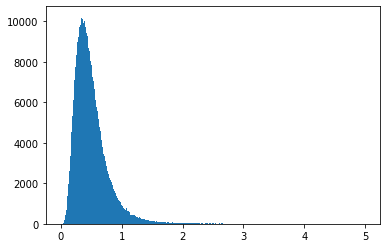

In [108]:
plt.hist(bb2_loss_bkg,bins=np.linspace(0,5,1001));

In [109]:
f_bb3 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5')
dt_bb3 = f_bb3.values

In [110]:
X_bb3 = dt_bb3[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [111]:
for i in range(12):
    X_bb3[:,i] = (X_bb3[:,i]-bkg_mean[i])/bkg_std[i]

In [137]:
bb3_loss_bkg = get_loss(X_bb3)

200


In [138]:
bb3_loss_bkg = np.array(bb3_loss_bkg,dtype=np.float)

In [139]:
bb3_loss_bkg

array([0.3940129 , 0.36679476, 0.56973112, ..., 0.26589143, 0.32429862,
       0.33480105])

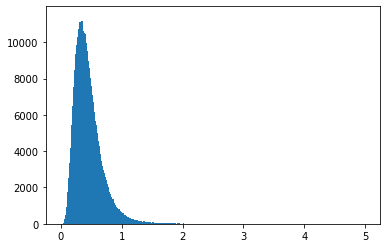

In [140]:
plt.hist(bb3_loss_bkg,bins=np.linspace(0,5,1001));

In [141]:
np.save('../data_strings/bkgaeloss_bb2.npy',bb2_loss_bkg)

In [142]:
np.save('../data_strings/bkgaeloss_bb3.npy',bb3_loss_bkg)

In [24]:
X[signal_idx].shape

(100000, 94)

In [72]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

(992924, 30)
(99829, 30)


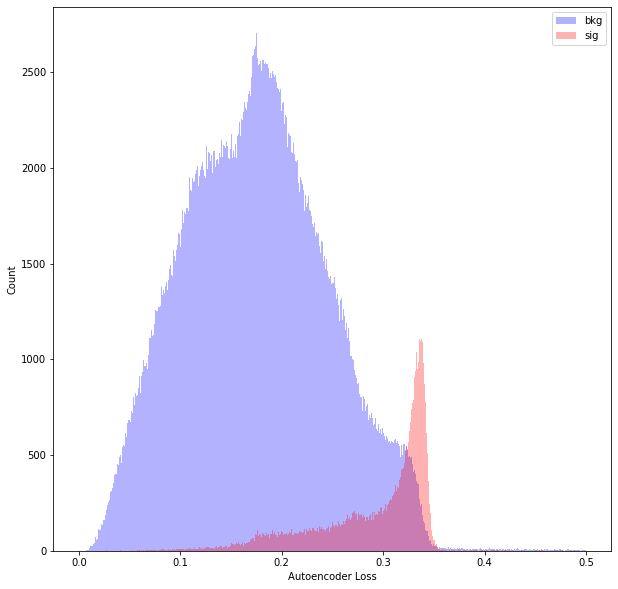

In [74]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)